Necessary Standard Imports

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score, roc_curve, auc, f1_score, confusion_matrix
from tqdm import tqdm
import seaborn as sns

Importing the Custom 

In [2]:
custom_modules_path = os.path.abspath(r'F:\Capstone\DFCA')

# Add the path to sys.path
if custom_modules_path not in sys.path:
    sys.path.append(custom_modules_path)

from scripts.pretrain_pipeline import FusedModel
from utils.augmentations import ComposeT, ToTensor, SpecTimePitchWarp, SpecAugment, GradCAM
from models.heads import AnomalyScorer, SimpleAnomalyMLP, EmbeddingMLP,ComplexAnomalyMLP
from models.losses import ContrastiveLoss
from utils.datasets import PairedSpectrogramDataset, PairedSpectrogramDatasetCS

f:\CapStone\DFCA\capstone\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Metrics and GradCam Utilities

In [3]:
def calculate_pAUC(labels, preds, max_fpr = 0.1):
    """
    Calculates Partial AUC (pAUC) for a given FPR range.
    Args:
        labels (array): True binary labels.
        preds (array): Predicted probabilities for the positive class.
        max_fpr (float): Maximum False Positive Rate for pAUC calculation.
    Returns:
        float: pAUC score.
    """
    if len(np.unique(labels)) < 2:
        return float('nan')
    
    fpr, tpr, _ = roc_curve(labels, preds)
    #filter for FPR <= max_fpr
    mask = fpr <= max_fpr
    fpr_filtered, tpr_filtered = fpr[mask], tpr[mask] 
      
    if fpr_filtered.size == 0:
        return 0.0

    if fpr_filtered.max() < max_fpr:
        idx = np.where(fpr <= max_fpr)[0][-1]
        if idx + 1 < len(fpr):
            x1, y1 = fpr[idx], tpr[idx]
            x2, y2 = fpr[idx + 1], tpr[idx + 1]
            tpr_interp = y1 + (y2 - y1) * (max_fpr - x1) / (x2 - x1) if (x2 - x1) > 0 else y1
            fpr_filtered = np.append(fpr_filtered, max_fpr)
            tpr_filtered = np.append(tpr_filtered, tpr_interp)
            sort_idx = np.argsort(fpr_filtered)
            fpr_filtered = fpr_filtered[sort_idx]
            tpr_filtered = tpr_filtered[sort_idx]

    return auc(fpr_filtered, tpr_filtered) / max_fpr if len(fpr_filtered) >= 2 else 0.0

def plot_confusion_matrix(y_true, y_pred, labels, save_path, title="Confusion Matrix"):
    """
        Plots a confusion matrix for model evaluation
    Args:
        y_true (list or np.array): Ground truth labels.
        y_pred (list or np.array): Predicted labels.
        labels (list): A list of labels for the matrix axes (['Normal', 'Abnormal'])
        title (str): Title for the plot
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp+fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"TP: {tp} | TN: {tn} | FP: {fp} | FN: {fn} | Precision: {precision:.4f} | Recall: {recall:.4f} | Specificity: {specificity:.4f}")
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(os.path.join(save_path, "Confusion Matrix.png"))
    plt.show()
    plt.close()
    
def find_last_conv(module, name_contains=None):
    """
    Returns (module_ref, full_name) of the last nn.Conv2d found in module.
    If name_contains is provided, prefer conv modules whose name includes that substring.
    """
    last = (None, None)
    for n,m in module.named_modules():
        if isinstance(m, nn.Conv2d):
            last = (m,n)
        
    if name_contains:
        # Try to find last conv with name containing substring
        cand = (None, None)
        for n, m in module.named_modules():
            if isinstance(m,nn.Conv2d) and name_contains in n.lower():
                cand = (m,n)
        
        if cand[0] is not None:
            return cand
    
    return last

# -------------------------------
# GradCAM Utilities
# -------------------------------
def prepare_gradcam_targets(model, device):
    """
    Heuristic: try to find conv layers for stft and cqt branches by name
    Fallback: the last conv in the model
    Return dict {'stft':module, 'cqt':module}
    """
    targets = {}
    stft_conv = find_last_conv(model, name_contains='stft')
    cqt_conv = find_last_conv(model, name_contains='cqt')

    if stft_conv[0] is None:
        stft_conv = find_last_conv(model, name_contains=None)
    if cqt_conv[0] is None:
        cqt_conv = find_last_conv(model, name_contains=None)
    
    targets['stft'] = stft_conv[0]
    targets['cqt'] = cqt_conv[0]
    
    return targets

def build_gradcam_for_model(model, device):
    targets = prepare_gradcam_targets(model, device)
    cams = {}
    if targets['stft'] is not None:
        cams['stft'] = GradCAM(model, targets['stft'])
    if targets['cqt'] is not None:
        cams['cqt'] = GradCAM(model, targets['cqt'])
    return cams

def run_and_save_gradcams(model, cams, dataset, device, out_dir="gradcam_outputs", n_samples=8):
    os.makedirs(out_dir, exist_ok=True)
    model.eval()
    saved = 0
    for i in range(len(dataset)):
        item = dataset[i]
        stft = item['stft'].unsqueeze(0).to(device)
        cqt = item['cqt'].unsqueeze(0).to(device)
        label = int(item['label'])

        #forward pass to get logtis
        logits = model(stft, cqt)
        #Pick scalar to backprop
        if logits.ndim == 2 and logits.shape[1] == 2:
            target_score = logits[:,1].squeeze()
        else:
            if logits.ndim == 2 and logits.shape[1] == 1:
                target_score = logits.squeeze(1)
            else:
                target_score = logits
        
        #stft gradcam
        for branch, cam in cams.items():
            try:
                scalar = target_score.sum()
                heat = cam.heatmap(stft if branch =='stft' else cqt, scalar, device)
            except Exception as e:
                print(f"GradCAM failed for sample {i} branch {branch}: {e}")
                heat = None
            
            # save overlay
            base = (stft.squeeze(0).cpu().numpy() if branch =='stft' else cqt.squeeze(0).cpu().numpy())
            if base.ndim == 3:
                base_img = base[0]
            else:
                base_img = base
            
            # normalize base_img to 0..1
            base_img = base_img - base_img.min()
            if base_img.max() > 0:
                base_img = base_img / base_img.max()
            # Save figure
            plt.figure(figsize=(6,4))
            plt.imshow(base_img, aspect='auto', origin='lower')
            if heat is not None:
                cmap = plt.get_cmap('jet')
                heat_resized = np.flipud(heat)
                plt.imshow(heat_resized, cmap=cmap, alpha=0.5, extent=(0,base_img.shape[1], 0, base_img.shape[0]))
            plt.title(f"GradCAM {branch.upper()} - label:{label} idx:{i}")
            fname = os.path.join(out_dir, f"gradcam_{branch}_idx_{i}_label{label}.png")
            plt.colorbar()
            plt.tight_layout()
            plt.savefig(fname)
            plt.close()
        saved +=1
        if saved >= n_samples:
            break

    # remove hooks
    for cam in cams.values():
        cam.remove_hooks()
    print(f"Saved {saved} GradCAM images to {out_dir}")

Configurations

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device} - {torch.cuda.get_device_name(0)}")

FEATURES_DIR = os.path.abspath(r'F:\Capstone\DFCA\data\features')
BATCH_SIZE = 32
NUM_EPOCHS = 50
LR = 5e-5
WEIGHT_DECAY = 1e-2
CHECKPOINT_DIR = os.path.abspath(r'F:\Capstone\DFCA\checkpoints')
CONTRASTIVE_MARGIN = 0.5
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
HEAD_MODE = 'mlp'
EMB_DIM = 64

save_path = os.path.join(CHECKPOINT_DIR,'DFCA', '[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)','ComplexMLP-75')
os.makedirs(os.path.dirname(save_path), exist_ok=True)

Using Device: cuda - NVIDIA GeForce MX450


Train & Evaluate Functions

In [5]:
def evaluate_model(model, data_loader, criterion, phase="Evaluation", device=device, head_mode='classifier', sample_count=10, threshold=0.5):
    """
    Evaluate a model on a given dataset.
    
    Args:
        model: PyTorch model to evaluate.
        data_loader: DataLoader for the dataset to evaluate on.
        criterion: Loss function.
        phase (str): Label for the evaluation phase (e.g., "Train", "Validation", "Test").
        device: Torch device ('cuda' or 'cpu').
        head_mode (str): Type of model head ('classifier', 'mlp', 'prototype', 'embedding').
        sample_count (int): Number of sample predictions to print for inspection.
        threshold (float): The classification threshold to use for binary predictions.

    Returns:
        avg_loss: Average loss over the dataset.
        auc_score: ROC AUC score.
        acc_score: Accuracy.
        bacc_score: Balanced accuracy.
        f1_score: F1-score.
        all_labels: List of all ground truth labels.
        all_probs: List of all predicted probabilities/scores for the positive class.
        best_threshold: The optimal threshold found, or the provided threshold.
    """
    model.eval()
    running_loss = 0.0
    all_labels, all_probs = [], []
    
    best_threshold = threshold
    f1 = 0.0
    # [DEBUG]
    class_counts = {0: 0, 1: 0}

    with torch.no_grad():
        for batch in tqdm(data_loader, desc=phase):
            stft = batch['stft'].to(device)
            cqt = batch['cqt'].to(device)
            labels = batch['label'].to(device).long()
            
            for lbl in labels.cpu().numpy():
                class_counts[int(lbl)] += 1
            
            loss = None
            if head_mode == "prototype":
                embeddings, prototype = model(stft, cqt)
                embeddings = F.normalize(embeddings, dim=1)
                prototype = F.normalize(prototype, dim=0)
                if prototype.dim() == 1:
                    prototype = prototype.unsqueeze(0)
                prototype = prototype.expand_as(embeddings)
                cos_sim = torch.sum(embeddings * prototype, dim=1)
                probs = 1 - cos_sim
                loss = criterion(embeddings, prototype, labels.float())
            
            elif head_mode in ["classifier", "mlp"]:
                logits = model(stft, cqt)
                if logits.ndim == 2 and logits.shape[1] == 2:
                    probs = torch.softmax(logits, dim=1)[:, 1]
                    loss = criterion(logits, labels.long())
                else:
                    if logits.ndim == 2 and logits.shape[1] == 1:
                        logits = logits.squeeze(1)
                    probs = torch.sigmoid(logits)
                    loss = criterion(logits, labels.float())
            
            elif head_mode == "embedding":
                embeddings = model(stft, cqt)
                normal_proto = model.head.normal_prototype
                embeddings = F.normalize(embeddings, dim=1)
                normal_proto = F.normalize(normal_proto, dim=0)
                cos_sim = torch.sum(embeddings * normal_proto.unsqueeze(0).expand_as(embeddings), dim=1)
                probs = 1 - cos_sim
                if isinstance(criterion, ContrastiveLoss):
                    loss = criterion(embeddings, normal_proto, labels)
                else:
                    loss = criterion(probs, labels.float())
            elif head_mode == 'classifier-1':
                logits = model(stft,cqt)
                if logits.ndim == 2 and logits.shape[1] ==1:
                    logits = logits.squeeze(1)
                probs = torch.sigmoid(logits)
                loss = criterion(logits, labels.float())
            
            else:
                raise ValueError(f"Unsupported head_mode:{head_mode}")
            
            running_loss += loss.item() * stft.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    print(f"[DEBUG] {phase} label counts: {class_counts}")
    
    # Logic for finding optimal threshold on Validation set
    f1 = 0.0 # Initialize f1
    if phase == "Validation":
        best_f1 = 0
        current_optimal_threshold = 0.5
        for thresh in np.arange(0.01, 1.0, 0.01):
            predictions_thresh = (np.array(all_probs) > thresh).astype(int)
            f1_candidate = f1_score(all_labels, predictions_thresh)
            if f1_candidate > best_f1:
                best_f1 = f1_candidate
                current_optimal_threshold = thresh

        best_threshold = current_optimal_threshold
        f1 = best_f1
        print(f"Optimal Threshold (F1-score): {best_threshold:.2f}")
        print(f"Best F1-score on Validation Set: {best_f1:.4f}")
    
    # Calculate all metrics using the selected or optimal threshold
    all_preds = (np.array(all_probs) > best_threshold).astype(int)
    if phase != "Validation":
        if len(np.unique(all_labels)) > 1:
            f1 = f1_score(all_labels, all_preds)
        else:
            f1 = 0.0
    
    avg_loss = running_loss / len(data_loader.dataset)
    auc_score = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else float('nan')
    acc_score = accuracy_score(all_labels, all_preds)
    bacc_score = balanced_accuracy_score(all_labels, all_preds)
    
    print(f"{phase} Loss: {avg_loss:.4f}, {phase} AUC: {auc_score:.4f}, {phase} ACC: {acc_score:.4f}, {phase} BACC: {bacc_score:.4f}")
    print(f"[DEBUG] {phase} Prediction Distribution: {dict(Counter(all_preds))}")
    print(f"[DEBUG] {phase} Label Distribution: {dict(Counter(all_labels))}")
    print("==================== Misclassification & Samples ====================")
    errors = [(i, p, pr, l) for i, (p, pr, l) in enumerate(zip(all_preds, all_probs, all_labels)) if p != l]
    print(f"{phase} Misclassified Samples: {len(errors)} / {len(all_labels)}")
    # for idx, pred, prob, label in errors[:10]:
    #     print(f"Idx {idx}: Pred = {pred}, Prob = {prob:.4f}, True = {label}")
    print("\nSample Predictions vs Labels:")
    for i in range(min(sample_count, len(all_labels))):
        print(f"Sample {i+1}: Pred = {all_preds[i]}, Prob = {all_probs[i]:.4f}, True = {all_labels[i]}")
    print("=====================================================================")
    
    return avg_loss, auc_score, acc_score, bacc_score, f1, all_labels, all_probs, best_threshold

# ---------------------------------
# Training
# ---------------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, head_mode, schedular=None, num_epochs=5, model_save_path="best_model.pth", device=device, save_plots=True):
    best_val_auc = -np.inf
    best_val_loss = np.inf
    current_threshold = 0.5
    best_threshold = 0.5

    train_losses, val_losses = [], []
    train_aucs, val_aucs = [], []
    train_accs, val_accs = [], []
    train_baccs, val_baccs = [], []

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels, all_probs, all_preds = [], [], []

        #DEBUG
        class_counts_train = {0:0, 1:0}
        epoch_stats = defaultdict(list)

        print(f"Epoch {epoch+1}/{num_epochs}")
        for batch in tqdm(train_loader, desc="Train"):
            stft = batch['stft'].to(device)
            cqt = batch['cqt'].to(device)
            labels = batch['label'].to(device).long()

            #DEBUG
            for lbl in labels.cpu().numpy():
                class_counts_train[int(lbl)] +=1

            optimizer.zero_grad()
            outputs = model(stft, cqt)

            if head_mode in ["classifier", "mlp"]:
                # Binary classification
                if outputs.ndim == 2 and outputs.shape[1] == 2:
                    probs = torch.softmax(outputs, dim=1)[:, 1]
                    preds = torch.argmax(outputs.detach().cpu(), dim=1)
                    loss = criterion(outputs, labels)
                else:
                    probs = torch.sigmoid(outputs.squeeze())
                    preds = (probs > current_threshold ).long()
                    loss = criterion(outputs.squeeze(), labels.float())
            elif head_mode == "prototype":
                embeddings, prototype = outputs
                #DEBUG STARTS
                #Cosine SIM LOGGING
                embeddings = F.normalize(embeddings, dim=1)
                prototype = F.normalize(prototype,dim=0)
                if prototype.dim() == 1:
                    prototype = prototype.unsqueeze(0)
                prototype = prototype.expand_as(embeddings)
                cos_sim = torch.sum(embeddings * prototype, dim=1)

                normal_sim = cos_sim[labels == 0].mean().item() if (labels == 0).any() else None
                anomaly_sim = cos_sim[labels ==1].mean().item() if (labels == 1).any() else None
                if normal_sim is not None:
                    epoch_stats['normal_sim'].append(normal_sim)
                if anomaly_sim is not None:
                    epoch_stats['anomaly_sim'].append(anomaly_sim)
                
                #DEBUG ENDS
                anomaly_scores = 1 - cos_sim 
                probs = anomaly_scores
                preds = (anomaly_scores > current_threshold).long()
                loss = criterion(embeddings, prototype, labels.float())

            elif head_mode == "embedding":
                embeddings = outputs
                normal_proto = model.head.normal_prototype
                
                #DEBUG STARTS
                embeddings = F.normalize(embeddings, dim=1)
                normal_proto = F.normalize(normal_proto, dim=0)
                cos_sim = torch.sum(embeddings * normal_proto.unsqueeze(0).expand_as(embeddings), dim=1)

                normal_sim = cos_sim[labels == 0].mean().item() if (labels == 0).any() else None
                anomaly_sim = cos_sim[labels == 1].mean().item() if (labels == 1).any() else None
                if normal_sim is not None:
                    epoch_stats['normal_sim'].append(normal_sim)
                if anomaly_sim is not None:
                    epoch_stats['anomaly_sim'].append(anomaly_sim)
                #DEBUG ENDS
                
                anomaly_scores = 1 - cos_sim 
                probs = anomaly_scores
                preds = (anomaly_scores > current_threshold).long()
                loss = criterion(embeddings,normal_proto, labels)
            
            elif head_mode == 'classifier-1':
                outputs = model(stft, cqt)
                probs = torch.sigmoid(outputs.squeeze())
                preds = (probs > current_threshold).long()
                loss = criterion(outputs.squeeze(), labels.float())
            else:
                raise ValueError(f"Unsupported head_mode: {head_mode}")
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * stft.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())
            all_preds.extend(preds.detach().cpu().numpy())
        #DEBUG
        print(f"[DEBUG] Train label counts (epoch {epoch+1}): {class_counts_train}") 
        if epoch_stats['normal_sim']:
            avg_normal_sim = sum(epoch_stats['normal_sim']) / len(epoch_stats['normal_sim'])
            avg_anomaly_sim = sum(epoch_stats['anomaly_sim']) / len(epoch_stats['anomaly_sim'])
            print(f"[DEBUG] Avg Normal CosSim: {avg_normal_sim:.4f}, Avg Anomaly CosSim: {avg_anomaly_sim:.4f}")
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_auc = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels))> 1 else float('nan')
        train_acc = accuracy_score(all_labels, all_preds)
        train_bacc = balanced_accuracy_score(all_labels, all_preds)
        train_aucs.append(train_auc)
        train_accs.append(train_acc)
        train_baccs.append(train_bacc)

        print(f"Train Loss: {epoch_loss:.4f} | Train AUC: {train_auc:.4f} | Train Acc: {train_acc:.4f}, | Train BAcc: {train_bacc:.4f}")

        # Validation
        val_loss, val_auc, val_acc, val_bacc, _, _, _, current_optimal_threshold = evaluate_model(model, val_loader, criterion, phase="Validation", device=device, head_mode=head_mode,sample_count=5)
        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        val_accs.append(val_acc)
        val_baccs.append(val_bacc)

        # scheduler step (per epoch)
        if schedular is not None:
            try:
                schedular.step()
            except Exception:
                pass
        print(f"Epoch {epoch+1}: Learning Rate = {optimizer.param_groups[0]['lr']:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            loss_path = model_save_path.replace(".pth", "_best_loss.pth")
            torch.save(model.state_dict(), loss_path)
            print(f"Saved Best-Loss model to {loss_path} (val_loss improved to {best_val_loss:.4f})")

        # Save by best AUC
        if not np.isnan(val_auc) and val_auc > best_val_auc:
            best_val_auc = val_auc
            best_threshold = current_optimal_threshold
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved Best-AUC model to {model_save_path} (val_auc improved to {best_val_auc:.4f})")
        else:
            print(f"Val AUC {val_auc:.4f} did not improved from best {best_val_auc:.4f}")
    
    if save_plots:
        epochs = range(1, num_epochs+1)
        plt.figure(figsize=(18,4))
        plt.subplot(1,4,1)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Val Loss')
        plt.legend()
        plt.grid(True)
        plt.title("Train/Validation Loss")

        plt.subplot(1, 4, 2)
        plt.plot(epochs, train_aucs, label='Train AUC')
        plt.plot(epochs, val_aucs, label='Val AUC')
        plt.legend()
        plt.grid(True)
        plt.title("Train/Validation AUC")

        plt.subplot(1, 4, 3)
        plt.plot(epochs, train_accs, label='Train Acc')
        plt.plot(epochs, val_accs, label='Val Acc')
        plt.legend()
        plt.grid(True)
        plt.title("Train/Validation Accuracy")

        plt.subplot(1, 4, 4)
        plt.plot(epochs, train_baccs, label='Train BAcc')
        plt.plot(epochs, val_baccs, label='Val BAcc')
        plt.legend()
        plt.grid(True)
        plt.title("Train/Validation Balanced Acc")

        plt.tight_layout()
        plt.savefig(os.path.join(save_path, "training_summary.png"))
        # plt.show()

    return best_threshold

Main Pine Line

Split sizes => Train: 2943, Val: 631, Test: 631
Label Distribution (Train): Counter({0: 2624, 1: 319})
Label Distribution (Validation): Counter({0: 562, 1: 69})
Label Distribution (Test): Counter({0: 563, 1: 68})
Epoch 1/50


Train: 100%|██████████| 91/91 [00:59<00:00,  1.54it/s]


[DEBUG] Train label counts (epoch 1): {0: 2595, 1: 317}
Train Loss: 1.2032 | Train AUC: 0.6274 | Train Acc: 0.4698, | Train BAcc: 0.5931


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.85it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.75
Best F1-score on Validation Set: 0.4079
Validation Loss: 1.0811, Validation AUC: 0.7602, Validation ACC: 0.8574, Validation BACC: 0.6784
[DEBUG] Validation Prediction Distribution: {np.int64(0): 548, np.int64(1): 83}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 90 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.4018, True = 0
Sample 2: Pred = 0, Prob = 0.4103, True = 0
Sample 3: Pred = 1, Prob = 0.7572, True = 1
Sample 4: Pred = 0, Prob = 0.4041, True = 0
Sample 5: Pred = 0, Prob = 0.3778, True = 0
Epoch 1: Learning Rate = 0.000050
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 1.0811)
Saved Best-AUC model to F:\Capstone\DFCA\chec

Train: 100%|██████████| 91/91 [00:59<00:00,  1.53it/s]


[DEBUG] Train label counts (epoch 2): {0: 2595, 1: 317}
Train Loss: 1.1064 | Train AUC: 0.7140 | Train Acc: 0.6367, | Train BAcc: 0.6591


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.80
Best F1-score on Validation Set: 0.4530
Validation Loss: 1.0745, Validation AUC: 0.8020, Validation ACC: 0.8431, Validation BACC: 0.7339
[DEBUG] Validation Prediction Distribution: {np.int64(0): 519, np.int64(1): 112}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 99 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.5430, True = 0
Sample 2: Pred = 0, Prob = 0.6008, True = 0
Sample 3: Pred = 1, Prob = 0.8707, True = 1
Sample 4: Pred = 0, Prob = 0.2513, True = 0
Sample 5: Pred = 0, Prob = 0.3206, True = 0
Epoch 2: Learning Rate = 0.000050
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 1.0745)
Saved Best-AUC model to F:\Capstone\DFCA\che

Train: 100%|██████████| 91/91 [01:04<00:00,  1.41it/s]


[DEBUG] Train label counts (epoch 3): {0: 2596, 1: 316}
Train Loss: 1.0574 | Train AUC: 0.7407 | Train Acc: 0.6490, | Train BAcc: 0.6948


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.59
Best F1-score on Validation Set: 0.5027
Validation Loss: 0.8842, Validation AUC: 0.8552, Validation ACC: 0.8526, Validation BACC: 0.7774
[DEBUG] Validation Prediction Distribution: {np.int64(0): 513, np.int64(1): 118}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 93 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.3551, True = 0
Sample 2: Pred = 0, Prob = 0.2352, True = 0
Sample 3: Pred = 0, Prob = 0.2896, True = 1
Sample 4: Pred = 0, Prob = 0.2140, True = 0
Sample 5: Pred = 0, Prob = 0.0718, True = 0
Epoch 3: Learning Rate = 0.000050
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.8842)
Saved Best-AUC model to F:\Capstone\DFCA\che

Train: 100%|██████████| 91/91 [01:08<00:00,  1.33it/s]


[DEBUG] Train label counts (epoch 4): {0: 2594, 1: 318}
Train Loss: 1.0235 | Train AUC: 0.7759 | Train Acc: 0.6734, | Train BAcc: 0.7146


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.64
Best F1-score on Validation Set: 0.5750
Validation Loss: 0.8480, Validation AUC: 0.8763, Validation ACC: 0.8922, Validation BACC: 0.7933
[DEBUG] Validation Prediction Distribution: {np.int64(0): 540, np.int64(1): 91}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 68 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.3035, True = 0
Sample 2: Pred = 0, Prob = 0.3119, True = 0
Sample 3: Pred = 0, Prob = 0.5442, True = 1
Sample 4: Pred = 0, Prob = 0.1581, True = 0
Sample 5: Pred = 0, Prob = 0.0882, True = 0
Epoch 4: Learning Rate = 0.000049
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.8480)
Saved Best-AUC model to F:\Capstone\DFCA\chec

Train: 100%|██████████| 91/91 [01:08<00:00,  1.33it/s]


[DEBUG] Train label counts (epoch 5): {0: 2596, 1: 316}
Train Loss: 0.9760 | Train AUC: 0.7910 | Train Acc: 0.6624, | Train BAcc: 0.7203


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.73
Best F1-score on Validation Set: 0.5698
Validation Loss: 0.8183, Validation AUC: 0.8778, Validation ACC: 0.8780, Validation BACC: 0.8171
[DEBUG] Validation Prediction Distribution: {np.int64(0): 521, np.int64(1): 110}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 77 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.3568, True = 0
Sample 2: Pred = 0, Prob = 0.2768, True = 0
Sample 3: Pred = 1, Prob = 0.8059, True = 1
Sample 4: Pred = 0, Prob = 0.1443, True = 0
Sample 5: Pred = 0, Prob = 0.0651, True = 0
Epoch 5: Learning Rate = 0.000049
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.8183)
Saved Best-AUC model to F:\Capstone\DFCA\che

Train: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]


[DEBUG] Train label counts (epoch 6): {0: 2596, 1: 316}
Train Loss: 0.9538 | Train AUC: 0.8006 | Train Acc: 0.6944, | Train BAcc: 0.7271


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.73
Best F1-score on Validation Set: 0.5556
Validation Loss: 0.7563, Validation AUC: 0.8857, Validation ACC: 0.8859, Validation BACC: 0.7834
[DEBUG] Validation Prediction Distribution: {np.int64(0): 538, np.int64(1): 93}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 72 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1744, True = 0
Sample 2: Pred = 0, Prob = 0.3485, True = 0
Sample 3: Pred = 1, Prob = 0.7794, True = 1
Sample 4: Pred = 0, Prob = 0.2017, True = 0
Sample 5: Pred = 0, Prob = 0.0018, True = 0
Epoch 6: Learning Rate = 0.000048
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.7563)
Saved Best-AUC model to F:\Capstone\DFCA\chec

Train: 100%|██████████| 91/91 [01:09<00:00,  1.31it/s]


[DEBUG] Train label counts (epoch 7): {0: 2597, 1: 315}
Train Loss: 0.9178 | Train AUC: 0.8222 | Train Acc: 0.7249, | Train BAcc: 0.7440


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.71it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.71
Best F1-score on Validation Set: 0.5909
Validation Loss: 0.7740, Validation AUC: 0.8819, Validation ACC: 0.8859, Validation BACC: 0.8279
[DEBUG] Validation Prediction Distribution: {np.int64(0): 524, np.int64(1): 107}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 72 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.2703, True = 0
Sample 2: Pred = 0, Prob = 0.1640, True = 0
Sample 3: Pred = 1, Prob = 0.7113, True = 1
Sample 4: Pred = 0, Prob = 0.0212, True = 0
Sample 5: Pred = 0, Prob = 0.0014, True = 0
Epoch 7: Learning Rate = 0.000048
Val AUC 0.8819 did not improved from best 0.8857
Epoch 8/50


Train: 100%|██████████| 91/91 [01:10<00:00,  1.29it/s]


[DEBUG] Train label counts (epoch 8): {0: 2599, 1: 313}
Train Loss: 0.9035 | Train AUC: 0.8254 | Train Acc: 0.7431, | Train BAcc: 0.7493


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.81
Best F1-score on Validation Set: 0.6081
Validation Loss: 0.7618, Validation AUC: 0.8975, Validation ACC: 0.9081, Validation BACC: 0.7958
[DEBUG] Validation Prediction Distribution: {np.int64(0): 552, np.int64(1): 79}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 58 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.3802, True = 0
Sample 2: Pred = 0, Prob = 0.2457, True = 0
Sample 3: Pred = 1, Prob = 0.8845, True = 1
Sample 4: Pred = 0, Prob = 0.1498, True = 0
Sample 5: Pred = 0, Prob = 0.0148, True = 0
Epoch 8: Learning Rate = 0.000047
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model.pth (val_auc improved to 0.8975)
Epoch 9/50


Train: 100%|██████████| 91/91 [01:07<00:00,  1.34it/s]


[DEBUG] Train label counts (epoch 9): {0: 2597, 1: 315}
Train Loss: 0.8431 | Train AUC: 0.8539 | Train Acc: 0.7634, | Train BAcc: 0.7781


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.83
Best F1-score on Validation Set: 0.5963
Validation Loss: 0.6996, Validation AUC: 0.9139, Validation ACC: 0.8970, Validation BACC: 0.8087
[DEBUG] Validation Prediction Distribution: {np.int64(0): 539, np.int64(1): 92}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 65 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1637, True = 0
Sample 2: Pred = 0, Prob = 0.1805, True = 0
Sample 3: Pred = 1, Prob = 0.8863, True = 1
Sample 4: Pred = 0, Prob = 0.0287, True = 0
Sample 5: Pred = 0, Prob = 0.0156, True = 0
Epoch 9: Learning Rate = 0.000046
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.6996)
Saved Best-AUC model to F:\Capstone\DFCA\chec

Train: 100%|██████████| 91/91 [01:04<00:00,  1.41it/s]


[DEBUG] Train label counts (epoch 10): {0: 2598, 1: 314}
Train Loss: 0.8320 | Train AUC: 0.8586 | Train Acc: 0.7479, | Train BAcc: 0.7803


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.78
Best F1-score on Validation Set: 0.6173
Validation Loss: 0.6787, Validation AUC: 0.9160, Validation ACC: 0.9017, Validation BACC: 0.8241
[DEBUG] Validation Prediction Distribution: {np.int64(0): 538, np.int64(1): 93}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 62 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1679, True = 0
Sample 2: Pred = 0, Prob = 0.1322, True = 0
Sample 3: Pred = 1, Prob = 0.7819, True = 1
Sample 4: Pred = 0, Prob = 0.0276, True = 0
Sample 5: Pred = 0, Prob = 0.0040, True = 0
Epoch 10: Learning Rate = 0.000045
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.6787)
Saved Best-AUC model to F:\Capstone\DFCA\che

Train: 100%|██████████| 91/91 [01:03<00:00,  1.43it/s]


[DEBUG] Train label counts (epoch 11): {0: 2599, 1: 313}
Train Loss: 0.7983 | Train AUC: 0.8681 | Train Acc: 0.7572, | Train BAcc: 0.7769


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.44it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.76
Best F1-score on Validation Set: 0.6389
Validation Loss: 0.6564, Validation AUC: 0.9180, Validation ACC: 0.9176, Validation BACC: 0.8075
[DEBUG] Validation Prediction Distribution: {np.int64(0): 556, np.int64(1): 75}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 52 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1667, True = 0
Sample 2: Pred = 0, Prob = 0.3698, True = 0
Sample 3: Pred = 0, Prob = 0.6274, True = 1
Sample 4: Pred = 0, Prob = 0.0144, True = 0
Sample 5: Pred = 0, Prob = 0.0003, True = 0
Epoch 11: Learning Rate = 0.000044
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.6564)
Saved Best-AUC model to F:\Capstone\DFCA\che

Train: 100%|██████████| 91/91 [01:03<00:00,  1.43it/s]


[DEBUG] Train label counts (epoch 12): {0: 2598, 1: 314}
Train Loss: 0.7732 | Train AUC: 0.8801 | Train Acc: 0.7970, | Train BAcc: 0.8051


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.88
Best F1-score on Validation Set: 0.5736
Validation Loss: 0.7786, Validation AUC: 0.8893, Validation ACC: 0.9128, Validation BACC: 0.7477
[DEBUG] Validation Prediction Distribution: {np.int64(0): 571, np.int64(1): 60}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 55 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.2211, True = 0
Sample 2: Pred = 0, Prob = 0.2272, True = 0
Sample 3: Pred = 0, Prob = 0.7923, True = 1
Sample 4: Pred = 0, Prob = 0.0472, True = 0
Sample 5: Pred = 0, Prob = 0.0302, True = 0
Epoch 12: Learning Rate = 0.000043
Val AUC 0.8893 did not improved from best 0.9180
Epoch 13/50


Train: 100%|██████████| 91/91 [01:03<00:00,  1.44it/s]


[DEBUG] Train label counts (epoch 13): {0: 2596, 1: 316}
Train Loss: 0.8109 | Train AUC: 0.8658 | Train Acc: 0.7661, | Train BAcc: 0.8035


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.73
Best F1-score on Validation Set: 0.6667
Validation Loss: 0.6465, Validation AUC: 0.9237, Validation ACC: 0.9223, Validation BACC: 0.8293
[DEBUG] Validation Prediction Distribution: {np.int64(0): 553, np.int64(1): 78}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 49 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1185, True = 0
Sample 2: Pred = 0, Prob = 0.1911, True = 0
Sample 3: Pred = 0, Prob = 0.6713, True = 1
Sample 4: Pred = 0, Prob = 0.0396, True = 0
Sample 5: Pred = 0, Prob = 0.0018, True = 0
Epoch 13: Learning Rate = 0.000042
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.6465)
Saved Best-AUC model to F:\Capstone\DFCA\che

Train: 100%|██████████| 91/91 [01:03<00:00,  1.43it/s]


[DEBUG] Train label counts (epoch 14): {0: 2600, 1: 312}
Train Loss: 0.7305 | Train AUC: 0.8894 | Train Acc: 0.8015, | Train BAcc: 0.8127


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.63
Best F1-score on Validation Set: 0.6667
Validation Loss: 0.6567, Validation AUC: 0.9280, Validation ACC: 0.9192, Validation BACC: 0.8402
[DEBUG] Validation Prediction Distribution: {np.int64(0): 547, np.int64(1): 84}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 51 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0812, True = 0
Sample 2: Pred = 0, Prob = 0.0816, True = 0
Sample 3: Pred = 0, Prob = 0.2914, True = 1
Sample 4: Pred = 0, Prob = 0.0061, True = 0
Sample 5: Pred = 0, Prob = 0.0007, True = 0
Epoch 14: Learning Rate = 0.000041
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model.pth (val_auc improved to 0.9280)
Epoch 15/50


Train: 100%|██████████| 91/91 [01:03<00:00,  1.43it/s]


[DEBUG] Train label counts (epoch 15): {0: 2594, 1: 318}
Train Loss: 0.7390 | Train AUC: 0.8927 | Train Acc: 0.7974, | Train BAcc: 0.8145


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.90
Best F1-score on Validation Set: 0.6917
Validation Loss: 0.6365, Validation AUC: 0.9270, Validation ACC: 0.9350, Validation BACC: 0.8173
[DEBUG] Validation Prediction Distribution: {np.int64(0): 567, np.int64(1): 64}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 41 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1572, True = 0
Sample 2: Pred = 0, Prob = 0.1792, True = 0
Sample 3: Pred = 0, Prob = 0.5214, True = 1
Sample 4: Pred = 0, Prob = 0.0051, True = 0
Sample 5: Pred = 0, Prob = 0.0017, True = 0
Epoch 15: Learning Rate = 0.000040
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.6365)
Val AUC 0.9270 did not improved from best 0.

Train: 100%|██████████| 91/91 [01:04<00:00,  1.42it/s]


[DEBUG] Train label counts (epoch 16): {0: 2597, 1: 315}
Train Loss: 0.7189 | Train AUC: 0.8950 | Train Acc: 0.8098, | Train BAcc: 0.8138


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.83
Best F1-score on Validation Set: 0.6950
Validation Loss: 0.6194, Validation AUC: 0.9292, Validation ACC: 0.9319, Validation BACC: 0.8346
[DEBUG] Validation Prediction Distribution: {np.int64(0): 559, np.int64(1): 72}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 43 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1678, True = 0
Sample 2: Pred = 0, Prob = 0.0746, True = 0
Sample 3: Pred = 0, Prob = 0.5973, True = 1
Sample 4: Pred = 0, Prob = 0.0010, True = 0
Sample 5: Pred = 0, Prob = 0.0003, True = 0
Epoch 16: Learning Rate = 0.000039
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.6194)
Saved Best-AUC model to F:\Capstone\DFCA\che

Train: 100%|██████████| 91/91 [01:02<00:00,  1.46it/s]


[DEBUG] Train label counts (epoch 17): {0: 2595, 1: 317}
Train Loss: 0.6641 | Train AUC: 0.9127 | Train Acc: 0.8400, | Train BAcc: 0.8534


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.81
Best F1-score on Validation Set: 0.6667
Validation Loss: 0.6670, Validation AUC: 0.9168, Validation ACC: 0.9208, Validation BACC: 0.8347
[DEBUG] Validation Prediction Distribution: {np.int64(0): 550, np.int64(1): 81}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 50 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0909, True = 0
Sample 2: Pred = 0, Prob = 0.1053, True = 0
Sample 3: Pred = 0, Prob = 0.1854, True = 1
Sample 4: Pred = 0, Prob = 0.0107, True = 0
Sample 5: Pred = 0, Prob = 0.0011, True = 0
Epoch 17: Learning Rate = 0.000037
Val AUC 0.9168 did not improved from best 0.9292
Epoch 18/50


Train: 100%|██████████| 91/91 [01:02<00:00,  1.45it/s]


[DEBUG] Train label counts (epoch 18): {0: 2596, 1: 316}
Train Loss: 0.7468 | Train AUC: 0.8880 | Train Acc: 0.8132, | Train BAcc: 0.8035


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.86
Best F1-score on Validation Set: 0.7143
Validation Loss: 0.6104, Validation AUC: 0.9278, Validation ACC: 0.9429, Validation BACC: 0.8154
[DEBUG] Validation Prediction Distribution: {np.int64(0): 574, np.int64(1): 57}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 36 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1072, True = 0
Sample 2: Pred = 0, Prob = 0.0478, True = 0
Sample 3: Pred = 0, Prob = 0.5274, True = 1
Sample 4: Pred = 0, Prob = 0.0027, True = 0
Sample 5: Pred = 0, Prob = 0.0002, True = 0
Epoch 18: Learning Rate = 0.000036
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.6104)
Val AUC 0.9278 did not improved from best 0.

Train: 100%|██████████| 91/91 [01:03<00:00,  1.44it/s]


[DEBUG] Train label counts (epoch 19): {0: 2598, 1: 314}
Train Loss: 0.6662 | Train AUC: 0.9115 | Train Acc: 0.8341, | Train BAcc: 0.8482


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.75
Best F1-score on Validation Set: 0.7413
Validation Loss: 0.5638, Validation AUC: 0.9399, Validation ACC: 0.9414, Validation BACC: 0.8654
[DEBUG] Validation Prediction Distribution: {np.int64(0): 557, np.int64(1): 74}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 37 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1377, True = 0
Sample 2: Pred = 0, Prob = 0.0681, True = 0
Sample 3: Pred = 0, Prob = 0.2133, True = 1
Sample 4: Pred = 0, Prob = 0.0060, True = 0
Sample 5: Pred = 0, Prob = 0.0001, True = 0
Epoch 19: Learning Rate = 0.000035
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.5638)
Saved Best-AUC model to F:\Capstone\DFCA\che

Train: 100%|██████████| 91/91 [01:03<00:00,  1.44it/s]


[DEBUG] Train label counts (epoch 20): {0: 2596, 1: 316}
Train Loss: 0.6510 | Train AUC: 0.9151 | Train Acc: 0.8492, | Train BAcc: 0.8446


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.82
Best F1-score on Validation Set: 0.6906
Validation Loss: 0.6397, Validation AUC: 0.9302, Validation ACC: 0.9319, Validation BACC: 0.8283
[DEBUG] Validation Prediction Distribution: {np.int64(0): 561, np.int64(1): 70}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 43 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1550, True = 0
Sample 2: Pred = 0, Prob = 0.1127, True = 0
Sample 3: Pred = 0, Prob = 0.6141, True = 1
Sample 4: Pred = 0, Prob = 0.0048, True = 0
Sample 5: Pred = 0, Prob = 0.0002, True = 0
Epoch 20: Learning Rate = 0.000033
Val AUC 0.9302 did not improved from best 0.9399
Epoch 21/50


Train: 100%|██████████| 91/91 [01:03<00:00,  1.42it/s]


[DEBUG] Train label counts (epoch 21): {0: 2594, 1: 318}
Train Loss: 0.6837 | Train AUC: 0.9074 | Train Acc: 0.8396, | Train BAcc: 0.8410


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.90
Best F1-score on Validation Set: 0.7077
Validation Loss: 0.5704, Validation AUC: 0.9360, Validation ACC: 0.9398, Validation BACC: 0.8200
[DEBUG] Validation Prediction Distribution: {np.int64(0): 570, np.int64(1): 61}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 38 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1030, True = 0
Sample 2: Pred = 0, Prob = 0.0651, True = 0
Sample 3: Pred = 0, Prob = 0.6256, True = 1
Sample 4: Pred = 0, Prob = 0.0063, True = 0
Sample 5: Pred = 0, Prob = 0.0008, True = 0
Epoch 21: Learning Rate = 0.000032
Val AUC 0.9360 did not improved from best 0.9399
Epoch 22/50


Train: 100%|██████████| 91/91 [01:03<00:00,  1.43it/s]


[DEBUG] Train label counts (epoch 22): {0: 2595, 1: 317}
Train Loss: 0.6530 | Train AUC: 0.9143 | Train Acc: 0.8448, | Train BAcc: 0.8520


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.86
Best F1-score on Validation Set: 0.6986
Validation Loss: 0.5882, Validation AUC: 0.9390, Validation ACC: 0.9303, Validation BACC: 0.8464
[DEBUG] Validation Prediction Distribution: {np.int64(0): 554, np.int64(1): 77}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 44 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1393, True = 0
Sample 2: Pred = 0, Prob = 0.0350, True = 0
Sample 3: Pred = 0, Prob = 0.7128, True = 1
Sample 4: Pred = 0, Prob = 0.0006, True = 0
Sample 5: Pred = 0, Prob = 0.0004, True = 0
Epoch 22: Learning Rate = 0.000030
Val AUC 0.9390 did not improved from best 0.9399
Epoch 23/50


Train: 100%|██████████| 91/91 [01:03<00:00,  1.43it/s]


[DEBUG] Train label counts (epoch 23): {0: 2597, 1: 315}
Train Loss: 0.6454 | Train AUC: 0.9174 | Train Acc: 0.8503, | Train BAcc: 0.8352


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.48it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.90
Best F1-score on Validation Set: 0.6912
Validation Loss: 0.6122, Validation AUC: 0.9316, Validation ACC: 0.9334, Validation BACC: 0.8228
[DEBUG] Validation Prediction Distribution: {np.int64(0): 564, np.int64(1): 67}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 42 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1075, True = 0
Sample 2: Pred = 0, Prob = 0.0140, True = 0
Sample 3: Pred = 0, Prob = 0.6023, True = 1
Sample 4: Pred = 0, Prob = 0.0001, True = 0
Sample 5: Pred = 0, Prob = 0.0000, True = 0
Epoch 23: Learning Rate = 0.000029
Val AUC 0.9316 did not improved from best 0.9399
Epoch 24/50


Train: 100%|██████████| 91/91 [01:02<00:00,  1.46it/s]


[DEBUG] Train label counts (epoch 24): {0: 2597, 1: 315}
Train Loss: 0.6372 | Train AUC: 0.9201 | Train Acc: 0.8506, | Train BAcc: 0.8479


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.46it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.87
Best F1-score on Validation Set: 0.6667
Validation Loss: 0.6343, Validation AUC: 0.9372, Validation ACC: 0.9176, Validation BACC: 0.8457
[DEBUG] Validation Prediction Distribution: {np.int64(0): 544, np.int64(1): 87}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 52 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1332, True = 0
Sample 2: Pred = 0, Prob = 0.0076, True = 0
Sample 3: Pred = 0, Prob = 0.6562, True = 1
Sample 4: Pred = 0, Prob = 0.0007, True = 0
Sample 5: Pred = 0, Prob = 0.0006, True = 0
Epoch 24: Learning Rate = 0.000027
Val AUC 0.9372 did not improved from best 0.9399
Epoch 25/50


Train: 100%|██████████| 91/91 [01:02<00:00,  1.45it/s]


[DEBUG] Train label counts (epoch 25): {0: 2595, 1: 317}
Train Loss: 0.5894 | Train AUC: 0.9315 | Train Acc: 0.8547, | Train BAcc: 0.8479


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.92
Best F1-score on Validation Set: 0.7481
Validation Loss: 0.5571, Validation AUC: 0.9432, Validation ACC: 0.9477, Validation BACC: 0.8435
[DEBUG] Validation Prediction Distribution: {np.int64(0): 569, np.int64(1): 62}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 33 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1184, True = 0
Sample 2: Pred = 0, Prob = 0.0212, True = 0
Sample 3: Pred = 0, Prob = 0.6402, True = 1
Sample 4: Pred = 0, Prob = 0.0010, True = 0
Sample 5: Pred = 0, Prob = 0.0002, True = 0
Epoch 25: Learning Rate = 0.000026
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.5571)
Saved Best-AUC model to F:\Capstone\DFCA\che

Train: 100%|██████████| 91/91 [01:03<00:00,  1.44it/s]


[DEBUG] Train label counts (epoch 26): {0: 2594, 1: 318}
Train Loss: 0.5662 | Train AUC: 0.9362 | Train Acc: 0.8565, | Train BAcc: 0.8711


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.90
Best F1-score on Validation Set: 0.6892
Validation Loss: 0.6217, Validation AUC: 0.9378, Validation ACC: 0.9271, Validation BACC: 0.8447
[DEBUG] Validation Prediction Distribution: {np.int64(0): 552, np.int64(1): 79}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 46 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1241, True = 0
Sample 2: Pred = 0, Prob = 0.0165, True = 0
Sample 3: Pred = 0, Prob = 0.7636, True = 1
Sample 4: Pred = 0, Prob = 0.0030, True = 0
Sample 5: Pred = 0, Prob = 0.0013, True = 0
Epoch 26: Learning Rate = 0.000024
Val AUC 0.9378 did not improved from best 0.9432
Epoch 27/50


Train: 100%|██████████| 91/91 [01:03<00:00,  1.44it/s]


[DEBUG] Train label counts (epoch 27): {0: 2596, 1: 316}
Train Loss: 0.5452 | Train AUC: 0.9406 | Train Acc: 0.8674, | Train BAcc: 0.8701


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.93
Best F1-score on Validation Set: 0.6957
Validation Loss: 0.6403, Validation AUC: 0.9367, Validation ACC: 0.9334, Validation BACC: 0.8291
[DEBUG] Validation Prediction Distribution: {np.int64(0): 562, np.int64(1): 69}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 42 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0995, True = 0
Sample 2: Pred = 0, Prob = 0.0069, True = 0
Sample 3: Pred = 0, Prob = 0.5928, True = 1
Sample 4: Pred = 0, Prob = 0.0013, True = 0
Sample 5: Pred = 0, Prob = 0.0007, True = 0
Epoch 27: Learning Rate = 0.000022
Val AUC 0.9367 did not improved from best 0.9432
Epoch 28/50


Train: 100%|██████████| 91/91 [01:03<00:00,  1.43it/s]


[DEBUG] Train label counts (epoch 28): {0: 2598, 1: 314}
Train Loss: 0.5985 | Train AUC: 0.9281 | Train Acc: 0.8503, | Train BAcc: 0.8503


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.90
Best F1-score on Validation Set: 0.7000
Validation Loss: 0.5695, Validation AUC: 0.9433, Validation ACC: 0.9334, Validation BACC: 0.8355
[DEBUG] Validation Prediction Distribution: {np.int64(0): 560, np.int64(1): 71}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 42 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1491, True = 0
Sample 2: Pred = 0, Prob = 0.0057, True = 0
Sample 3: Pred = 0, Prob = 0.6408, True = 1
Sample 4: Pred = 0, Prob = 0.0007, True = 0
Sample 5: Pred = 0, Prob = 0.0002, True = 0
Epoch 28: Learning Rate = 0.000021
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model.pth (val_auc improved to 0.9433)
Epoch 29/50


Train: 100%|██████████| 91/91 [01:03<00:00,  1.43it/s]


[DEBUG] Train label counts (epoch 29): {0: 2595, 1: 317}
Train Loss: 0.5870 | Train AUC: 0.9326 | Train Acc: 0.8541, | Train BAcc: 0.8627


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.91
Best F1-score on Validation Set: 0.7353
Validation Loss: 0.5749, Validation AUC: 0.9431, Validation ACC: 0.9429, Validation BACC: 0.8472
[DEBUG] Validation Prediction Distribution: {np.int64(0): 564, np.int64(1): 67}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 36 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0932, True = 0
Sample 2: Pred = 0, Prob = 0.0142, True = 0
Sample 3: Pred = 0, Prob = 0.6491, True = 1
Sample 4: Pred = 0, Prob = 0.0014, True = 0
Sample 5: Pred = 0, Prob = 0.0001, True = 0
Epoch 29: Learning Rate = 0.000019
Val AUC 0.9431 did not improved from best 0.9433
Epoch 30/50


Train: 100%|██████████| 91/91 [01:02<00:00,  1.46it/s]


[DEBUG] Train label counts (epoch 30): {0: 2598, 1: 314}
Train Loss: 0.5305 | Train AUC: 0.9447 | Train Acc: 0.8681, | Train BAcc: 0.8673


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.46it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.84
Best F1-score on Validation Set: 0.7133
Validation Loss: 0.5756, Validation AUC: 0.9402, Validation ACC: 0.9350, Validation BACC: 0.8491
[DEBUG] Validation Prediction Distribution: {np.int64(0): 557, np.int64(1): 74}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 41 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0890, True = 0
Sample 2: Pred = 0, Prob = 0.0032, True = 0
Sample 3: Pred = 1, Prob = 0.8503, True = 1
Sample 4: Pred = 0, Prob = 0.0006, True = 0
Sample 5: Pred = 0, Prob = 0.0002, True = 0
Epoch 30: Learning Rate = 0.000018
Val AUC 0.9402 did not improved from best 0.9433
Epoch 31/50


Train: 100%|██████████| 91/91 [01:02<00:00,  1.45it/s]


[DEBUG] Train label counts (epoch 31): {0: 2596, 1: 316}
Train Loss: 0.5791 | Train AUC: 0.9334 | Train Acc: 0.8599, | Train BAcc: 0.8561


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.84
Best F1-score on Validation Set: 0.7353
Validation Loss: 0.5287, Validation AUC: 0.9471, Validation ACC: 0.9429, Validation BACC: 0.8472
[DEBUG] Validation Prediction Distribution: {np.int64(0): 564, np.int64(1): 67}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 36 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0762, True = 0
Sample 2: Pred = 0, Prob = 0.0033, True = 0
Sample 3: Pred = 0, Prob = 0.5400, True = 1
Sample 4: Pred = 0, Prob = 0.0006, True = 0
Sample 5: Pred = 0, Prob = 0.0005, True = 0
Epoch 31: Learning Rate = 0.000016
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.5287)
Saved Best-AUC model to F:\Capstone\DFCA\che

Train: 100%|██████████| 91/91 [01:02<00:00,  1.45it/s]


[DEBUG] Train label counts (epoch 32): {0: 2595, 1: 317}
Train Loss: 0.5436 | Train AUC: 0.9418 | Train Acc: 0.8808, | Train BAcc: 0.8764


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.90
Best F1-score on Validation Set: 0.7313
Validation Loss: 0.5195, Validation AUC: 0.9501, Validation ACC: 0.9429, Validation BACC: 0.8408
[DEBUG] Validation Prediction Distribution: {np.int64(0): 566, np.int64(1): 65}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 36 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0901, True = 0
Sample 2: Pred = 0, Prob = 0.0149, True = 0
Sample 3: Pred = 0, Prob = 0.5767, True = 1
Sample 4: Pred = 0, Prob = 0.0038, True = 0
Sample 5: Pred = 0, Prob = 0.0009, True = 0
Epoch 32: Learning Rate = 0.000015
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.5195)
Saved Best-AUC model to F:\Capstone\DFCA\che

Train: 100%|██████████| 91/91 [01:02<00:00,  1.45it/s]


[DEBUG] Train label counts (epoch 33): {0: 2599, 1: 313}
Train Loss: 0.5366 | Train AUC: 0.9430 | Train Acc: 0.8760, | Train BAcc: 0.8701


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.94
Best F1-score on Validation Set: 0.7481
Validation Loss: 0.5282, Validation AUC: 0.9508, Validation ACC: 0.9477, Validation BACC: 0.8435
[DEBUG] Validation Prediction Distribution: {np.int64(0): 569, np.int64(1): 62}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 33 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1217, True = 0
Sample 2: Pred = 0, Prob = 0.0052, True = 0
Sample 3: Pred = 0, Prob = 0.7365, True = 1
Sample 4: Pred = 0, Prob = 0.0008, True = 0
Sample 5: Pred = 0, Prob = 0.0002, True = 0
Epoch 33: Learning Rate = 0.000014
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model.pth (val_auc improved to 0.9508)
Epoch 34/50


Train: 100%|██████████| 91/91 [01:04<00:00,  1.40it/s]


[DEBUG] Train label counts (epoch 34): {0: 2595, 1: 317}
Train Loss: 0.5176 | Train AUC: 0.9479 | Train Acc: 0.8795, | Train BAcc: 0.8714


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.88
Best F1-score on Validation Set: 0.7429
Validation Loss: 0.5089, Validation AUC: 0.9518, Validation ACC: 0.9429, Validation BACC: 0.8599
[DEBUG] Validation Prediction Distribution: {np.int64(0): 560, np.int64(1): 71}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 36 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1030, True = 0
Sample 2: Pred = 0, Prob = 0.0064, True = 0
Sample 3: Pred = 0, Prob = 0.6947, True = 1
Sample 4: Pred = 0, Prob = 0.0014, True = 0
Sample 5: Pred = 0, Prob = 0.0004, True = 0
Epoch 34: Learning Rate = 0.000012
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.5089)
Saved Best-AUC model to F:\Capstone\DFCA\che

Train: 100%|██████████| 91/91 [01:04<00:00,  1.42it/s]


[DEBUG] Train label counts (epoch 35): {0: 2602, 1: 310}
Train Loss: 0.4804 | Train AUC: 0.9530 | Train Acc: 0.8990, | Train BAcc: 0.8853


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.85
Best F1-score on Validation Set: 0.7714
Validation Loss: 0.5177, Validation AUC: 0.9508, Validation ACC: 0.9493, Validation BACC: 0.8762
[DEBUG] Validation Prediction Distribution: {np.int64(0): 560, np.int64(1): 71}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 32 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0742, True = 0
Sample 2: Pred = 0, Prob = 0.0049, True = 0
Sample 3: Pred = 0, Prob = 0.6130, True = 1
Sample 4: Pred = 0, Prob = 0.0014, True = 0
Sample 5: Pred = 0, Prob = 0.0003, True = 0
Epoch 35: Learning Rate = 0.000011
Val AUC 0.9508 did not improved from best 0.9518
Epoch 36/50


Train: 100%|██████████| 91/91 [01:02<00:00,  1.47it/s]


[DEBUG] Train label counts (epoch 36): {0: 2595, 1: 317}
Train Loss: 0.5080 | Train AUC: 0.9486 | Train Acc: 0.8846, | Train BAcc: 0.8854


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.91
Best F1-score on Validation Set: 0.7656
Validation Loss: 0.5180, Validation AUC: 0.9484, Validation ACC: 0.9525, Validation BACC: 0.8462
[DEBUG] Validation Prediction Distribution: {np.int64(0): 572, np.int64(1): 59}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 30 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1000, True = 0
Sample 2: Pred = 0, Prob = 0.0050, True = 0
Sample 3: Pred = 0, Prob = 0.6225, True = 1
Sample 4: Pred = 0, Prob = 0.0020, True = 0
Sample 5: Pred = 0, Prob = 0.0006, True = 0
Epoch 36: Learning Rate = 0.000010
Val AUC 0.9484 did not improved from best 0.9518
Epoch 37/50


Train: 100%|██████████| 91/91 [01:02<00:00,  1.45it/s]


[DEBUG] Train label counts (epoch 37): {0: 2597, 1: 315}
Train Loss: 0.5173 | Train AUC: 0.9468 | Train Acc: 0.8915, | Train BAcc: 0.8820


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.48it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.92
Best F1-score on Validation Set: 0.7786
Validation Loss: 0.5185, Validation AUC: 0.9506, Validation ACC: 0.9540, Validation BACC: 0.8598
[DEBUG] Validation Prediction Distribution: {np.int64(0): 569, np.int64(1): 62}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 29 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0924, True = 0
Sample 2: Pred = 0, Prob = 0.0104, True = 0
Sample 3: Pred = 0, Prob = 0.6207, True = 1
Sample 4: Pred = 0, Prob = 0.0049, True = 0
Sample 5: Pred = 0, Prob = 0.0012, True = 0
Epoch 37: Learning Rate = 0.000009
Val AUC 0.9506 did not improved from best 0.9518
Epoch 38/50


Train: 100%|██████████| 91/91 [01:02<00:00,  1.45it/s]


[DEBUG] Train label counts (epoch 38): {0: 2598, 1: 314}
Train Loss: 0.4894 | Train AUC: 0.9520 | Train Acc: 0.8887, | Train BAcc: 0.8942


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.44it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.87
Best F1-score on Validation Set: 0.7794
Validation Loss: 0.5208, Validation AUC: 0.9507, Validation ACC: 0.9525, Validation BACC: 0.8716
[DEBUG] Validation Prediction Distribution: {np.int64(0): 564, np.int64(1): 67}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 30 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0702, True = 0
Sample 2: Pred = 0, Prob = 0.0080, True = 0
Sample 3: Pred = 0, Prob = 0.5963, True = 1
Sample 4: Pred = 0, Prob = 0.0040, True = 0
Sample 5: Pred = 0, Prob = 0.0013, True = 0
Epoch 38: Learning Rate = 0.000008
Val AUC 0.9507 did not improved from best 0.9518
Epoch 39/50


Train: 100%|██████████| 91/91 [01:03<00:00,  1.44it/s]


[DEBUG] Train label counts (epoch 39): {0: 2596, 1: 316}
Train Loss: 0.4555 | Train AUC: 0.9597 | Train Acc: 0.9059, | Train BAcc: 0.8986


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.92
Best F1-score on Validation Set: 0.7656
Validation Loss: 0.5296, Validation AUC: 0.9487, Validation ACC: 0.9525, Validation BACC: 0.8462
[DEBUG] Validation Prediction Distribution: {np.int64(0): 572, np.int64(1): 59}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 30 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0910, True = 0
Sample 2: Pred = 0, Prob = 0.0029, True = 0
Sample 3: Pred = 0, Prob = 0.5075, True = 1
Sample 4: Pred = 0, Prob = 0.0012, True = 0
Sample 5: Pred = 0, Prob = 0.0004, True = 0
Epoch 39: Learning Rate = 0.000007
Val AUC 0.9487 did not improved from best 0.9518
Epoch 40/50


Train: 100%|██████████| 91/91 [01:02<00:00,  1.44it/s]


[DEBUG] Train label counts (epoch 40): {0: 2596, 1: 316}
Train Loss: 0.4745 | Train AUC: 0.9554 | Train Acc: 0.8939, | Train BAcc: 0.8918


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.91
Best F1-score on Validation Set: 0.7704
Validation Loss: 0.5131, Validation AUC: 0.9511, Validation ACC: 0.9509, Validation BACC: 0.8644
[DEBUG] Validation Prediction Distribution: {np.int64(0): 565, np.int64(1): 66}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 31 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0789, True = 0
Sample 2: Pred = 0, Prob = 0.0049, True = 0
Sample 3: Pred = 0, Prob = 0.6328, True = 1
Sample 4: Pred = 0, Prob = 0.0028, True = 0
Sample 5: Pred = 0, Prob = 0.0009, True = 0
Epoch 40: Learning Rate = 0.000006
Val AUC 0.9511 did not improved from best 0.9518
Epoch 41/50


Train: 100%|██████████| 91/91 [01:02<00:00,  1.45it/s]


[DEBUG] Train label counts (epoch 41): {0: 2597, 1: 315}
Train Loss: 0.4544 | Train AUC: 0.9590 | Train Acc: 0.8970, | Train BAcc: 0.8934


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.90
Best F1-score on Validation Set: 0.7737
Validation Loss: 0.5268, Validation AUC: 0.9498, Validation ACC: 0.9509, Validation BACC: 0.8707
[DEBUG] Validation Prediction Distribution: {np.int64(0): 563, np.int64(1): 68}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 31 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0773, True = 0
Sample 2: Pred = 0, Prob = 0.0032, True = 0
Sample 3: Pred = 0, Prob = 0.6823, True = 1
Sample 4: Pred = 0, Prob = 0.0015, True = 0
Sample 5: Pred = 0, Prob = 0.0004, True = 0
Epoch 41: Learning Rate = 0.000005
Val AUC 0.9498 did not improved from best 0.9518
Epoch 42/50


Train: 100%|██████████| 91/91 [01:03<00:00,  1.43it/s]


[DEBUG] Train label counts (epoch 42): {0: 2595, 1: 317}
Train Loss: 0.4797 | Train AUC: 0.9555 | Train Acc: 0.8956, | Train BAcc: 0.8888


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.81
Best F1-score on Validation Set: 0.7550
Validation Loss: 0.5274, Validation AUC: 0.9489, Validation ACC: 0.9414, Validation BACC: 0.8908
[DEBUG] Validation Prediction Distribution: {np.int64(0): 549, np.int64(1): 82}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 37 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0688, True = 0
Sample 2: Pred = 0, Prob = 0.0033, True = 0
Sample 3: Pred = 0, Prob = 0.7253, True = 1
Sample 4: Pred = 0, Prob = 0.0016, True = 0
Sample 5: Pred = 0, Prob = 0.0004, True = 0
Epoch 42: Learning Rate = 0.000004
Val AUC 0.9489 did not improved from best 0.9518
Epoch 43/50


Train: 100%|██████████| 91/91 [01:03<00:00,  1.43it/s]


[DEBUG] Train label counts (epoch 43): {0: 2597, 1: 315}
Train Loss: 0.4307 | Train AUC: 0.9642 | Train Acc: 0.8997, | Train BAcc: 0.9005


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.84
Best F1-score on Validation Set: 0.7639
Validation Loss: 0.5180, Validation AUC: 0.9508, Validation ACC: 0.9461, Validation BACC: 0.8808
[DEBUG] Validation Prediction Distribution: {np.int64(0): 556, np.int64(1): 75}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 34 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0619, True = 0
Sample 2: Pred = 0, Prob = 0.0028, True = 0
Sample 3: Pred = 0, Prob = 0.6955, True = 1
Sample 4: Pred = 0, Prob = 0.0014, True = 0
Sample 5: Pred = 0, Prob = 0.0004, True = 0
Epoch 43: Learning Rate = 0.000003
Val AUC 0.9508 did not improved from best 0.9518
Epoch 44/50


Train: 100%|██████████| 91/91 [01:04<00:00,  1.42it/s]


[DEBUG] Train label counts (epoch 44): {0: 2596, 1: 316}
Train Loss: 0.5058 | Train AUC: 0.9481 | Train Acc: 0.9008, | Train BAcc: 0.8929


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.86
Best F1-score on Validation Set: 0.7552
Validation Loss: 0.5249, Validation AUC: 0.9491, Validation ACC: 0.9445, Validation BACC: 0.8735
[DEBUG] Validation Prediction Distribution: {np.int64(0): 557, np.int64(1): 74}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 35 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0811, True = 0
Sample 2: Pred = 0, Prob = 0.0030, True = 0
Sample 3: Pred = 0, Prob = 0.6367, True = 1
Sample 4: Pred = 0, Prob = 0.0012, True = 0
Sample 5: Pred = 0, Prob = 0.0004, True = 0
Epoch 44: Learning Rate = 0.000003
Val AUC 0.9491 did not improved from best 0.9518
Epoch 45/50


Train: 100%|██████████| 91/91 [01:04<00:00,  1.41it/s]


[DEBUG] Train label counts (epoch 45): {0: 2595, 1: 317}
Train Loss: 0.4393 | Train AUC: 0.9621 | Train Acc: 0.9018, | Train BAcc: 0.8992


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.87
Best F1-score on Validation Set: 0.7826
Validation Loss: 0.5124, Validation AUC: 0.9510, Validation ACC: 0.9525, Validation BACC: 0.8780
[DEBUG] Validation Prediction Distribution: {np.int64(0): 562, np.int64(1): 69}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 30 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0813, True = 0
Sample 2: Pred = 0, Prob = 0.0035, True = 0
Sample 3: Pred = 0, Prob = 0.5836, True = 1
Sample 4: Pred = 0, Prob = 0.0016, True = 0
Sample 5: Pred = 0, Prob = 0.0005, True = 0
Epoch 45: Learning Rate = 0.000002
Val AUC 0.9510 did not improved from best 0.9518
Epoch 46/50


Train: 100%|██████████| 91/91 [01:02<00:00,  1.46it/s]


[DEBUG] Train label counts (epoch 46): {0: 2595, 1: 317}
Train Loss: 0.4436 | Train AUC: 0.9608 | Train Acc: 0.9045, | Train BAcc: 0.8980


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.89
Best F1-score on Validation Set: 0.7737
Validation Loss: 0.5253, Validation AUC: 0.9486, Validation ACC: 0.9509, Validation BACC: 0.8707
[DEBUG] Validation Prediction Distribution: {np.int64(0): 563, np.int64(1): 68}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 31 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0735, True = 0
Sample 2: Pred = 0, Prob = 0.0039, True = 0
Sample 3: Pred = 0, Prob = 0.5410, True = 1
Sample 4: Pred = 0, Prob = 0.0015, True = 0
Sample 5: Pred = 0, Prob = 0.0005, True = 0
Epoch 46: Learning Rate = 0.000002
Val AUC 0.9486 did not improved from best 0.9518
Epoch 47/50


Train: 100%|██████████| 91/91 [01:03<00:00,  1.42it/s]


[DEBUG] Train label counts (epoch 47): {0: 2598, 1: 314}
Train Loss: 0.4181 | Train AUC: 0.9651 | Train Acc: 0.9059, | Train BAcc: 0.9081


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.88
Best F1-score on Validation Set: 0.7826
Validation Loss: 0.5111, Validation AUC: 0.9509, Validation ACC: 0.9525, Validation BACC: 0.8780
[DEBUG] Validation Prediction Distribution: {np.int64(0): 562, np.int64(1): 69}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 30 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0741, True = 0
Sample 2: Pred = 0, Prob = 0.0044, True = 0
Sample 3: Pred = 0, Prob = 0.5731, True = 1
Sample 4: Pred = 0, Prob = 0.0022, True = 0
Sample 5: Pred = 0, Prob = 0.0007, True = 0
Epoch 47: Learning Rate = 0.000001
Val AUC 0.9509 did not improved from best 0.9518
Epoch 48/50


Train: 100%|██████████| 91/91 [01:03<00:00,  1.42it/s]


[DEBUG] Train label counts (epoch 48): {0: 2598, 1: 314}
Train Loss: 0.4380 | Train AUC: 0.9615 | Train Acc: 0.9083, | Train BAcc: 0.9080


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.88
Best F1-score on Validation Set: 0.7746
Validation Loss: 0.5249, Validation AUC: 0.9512, Validation ACC: 0.9493, Validation BACC: 0.8825
[DEBUG] Validation Prediction Distribution: {np.int64(0): 558, np.int64(1): 73}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 32 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0736, True = 0
Sample 2: Pred = 0, Prob = 0.0029, True = 0
Sample 3: Pred = 0, Prob = 0.6110, True = 1
Sample 4: Pred = 0, Prob = 0.0015, True = 0
Sample 5: Pred = 0, Prob = 0.0005, True = 0
Epoch 48: Learning Rate = 0.000001
Val AUC 0.9512 did not improved from best 0.9518
Epoch 49/50


Train: 100%|██████████| 91/91 [01:03<00:00,  1.43it/s]


[DEBUG] Train label counts (epoch 49): {0: 2597, 1: 315}
Train Loss: 0.4254 | Train AUC: 0.9643 | Train Acc: 0.9100, | Train BAcc: 0.9063


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.89
Best F1-score on Validation Set: 0.7761
Validation Loss: 0.5212, Validation AUC: 0.9496, Validation ACC: 0.9525, Validation BACC: 0.8652
[DEBUG] Validation Prediction Distribution: {np.int64(0): 566, np.int64(1): 65}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 30 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0654, True = 0
Sample 2: Pred = 0, Prob = 0.0027, True = 0
Sample 3: Pred = 0, Prob = 0.5324, True = 1
Sample 4: Pred = 0, Prob = 0.0012, True = 0
Sample 5: Pred = 0, Prob = 0.0004, True = 0
Epoch 49: Learning Rate = 0.000001
Val AUC 0.9496 did not improved from best 0.9518
Epoch 50/50


Train: 100%|██████████| 91/91 [01:03<00:00,  1.43it/s]


[DEBUG] Train label counts (epoch 50): {0: 2597, 1: 315}
Train Loss: 0.4484 | Train AUC: 0.9597 | Train Acc: 0.9059, | Train BAcc: 0.8984


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.94
Best F1-score on Validation Set: 0.7717
Validation Loss: 0.5223, Validation AUC: 0.9508, Validation ACC: 0.9540, Validation BACC: 0.8471
[DEBUG] Validation Prediction Distribution: {np.int64(0): 573, np.int64(1): 58}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 29 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0708, True = 0
Sample 2: Pred = 0, Prob = 0.0034, True = 0
Sample 3: Pred = 0, Prob = 0.5796, True = 1
Sample 4: Pred = 0, Prob = 0.0018, True = 0
Sample 5: Pred = 0, Prob = 0.0006, True = 0
Epoch 50: Learning Rate = 0.000001
Val AUC 0.9508 did not improved from best 0.9518

--- Final Test Evaluation ---


Test: 100%|██████████| 20/20 [00:04<00:00,  4.84it/s]


[DEBUG] Test label counts: {0: 563, 1: 68}
Test Loss: 0.6807, Test AUC: 0.9123, Test ACC: 0.9255, Test BACC: 0.7902
[DEBUG] Test Prediction Distribution: {np.int64(0): 568, np.int64(1): 63}
[DEBUG] Test Label Distribution: {np.int64(0): 563, np.int64(1): 68}
==================== Misclassification & Samples ====================
Test Misclassified Samples: 47 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0048, True = 0
Sample 2: Pred = 0, Prob = 0.1526, True = 1
Sample 3: Pred = 0, Prob = 0.0060, True = 0
Sample 4: Pred = 1, Prob = 0.9909, True = 1
Sample 5: Pred = 0, Prob = 0.8747, True = 0

Final Test Metrics (with best validation threshold 0.88):
Loss: 0.6807 | AUC: 0.9123 | Accuracy: 0.9255 | Balanced Accuracy: 0.7902 | F1-Score: 0.6412
Final Test pAUC (FPR <= 0.2): 0.7309
TP: 42 | TN: 542 | FP: 21 | FN: 26 | Precision: 0.6667 | Recall: 0.6176 | Specificity: 0.9627


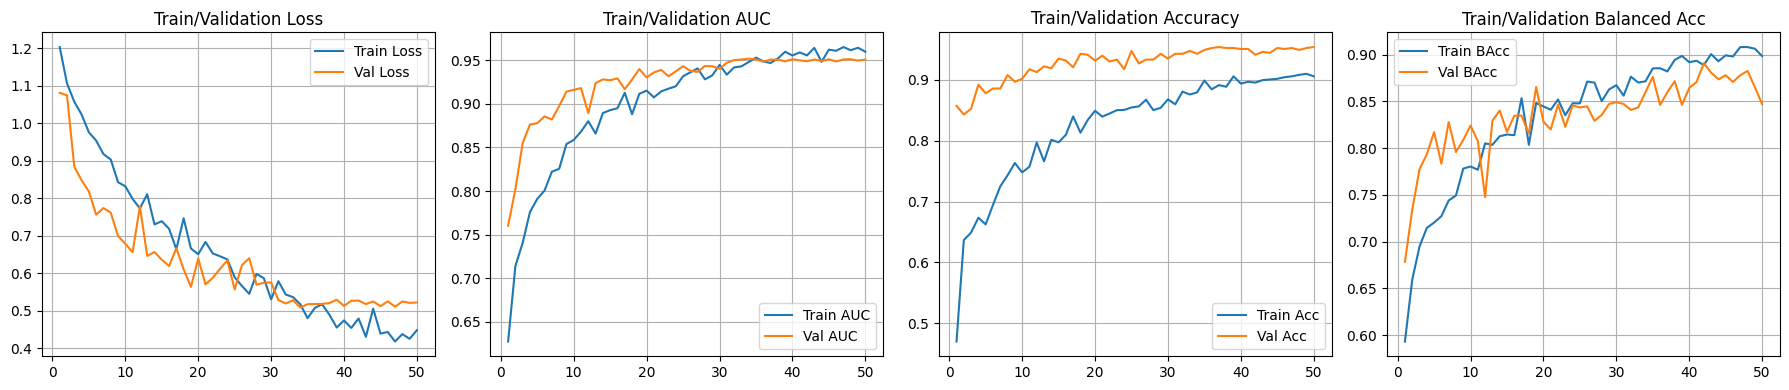

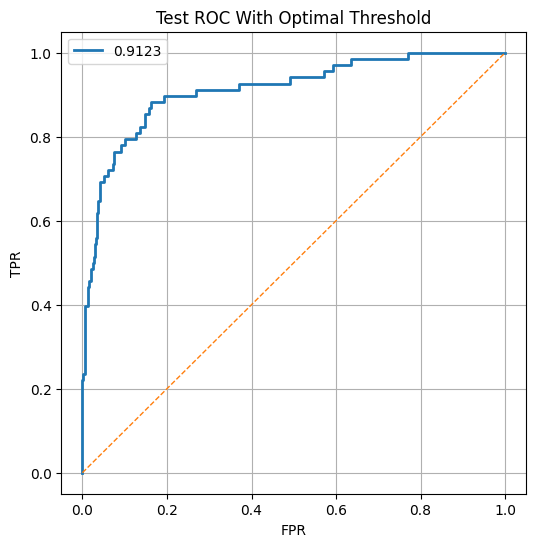

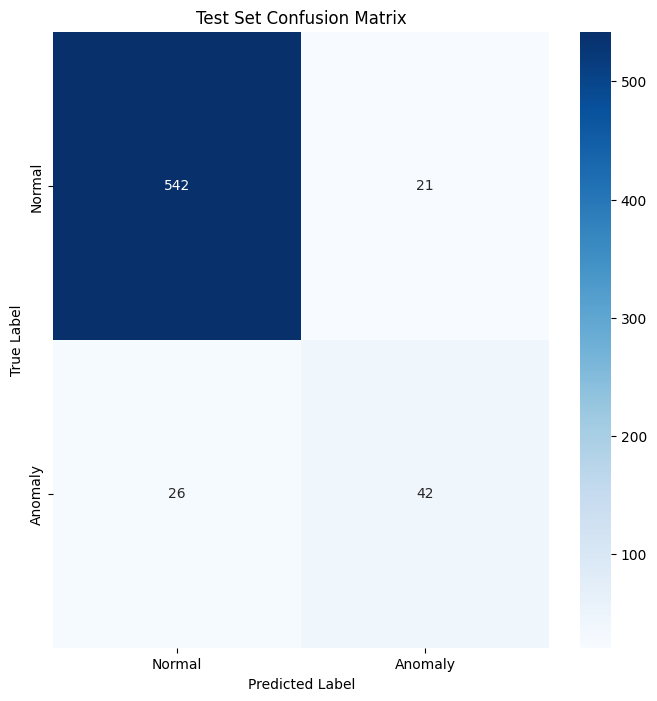

Saved 8 GradCAM images to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\gradcam


In [7]:
# ================================
# Main Pipeline 
# ================================
def main():
    
    SEED = 42
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    train_transforms = ComposeT([
        ToTensor(),
        SpecTimePitchWarp(max_time_scale=1.1, max_freq_scale=1.1),
        SpecAugment(freq_mask_param=4, time_mask_param=4, n_freq_masks=1, n_time_masks=1),
    ])

    no_transform = ComposeT([
        ToTensor(),
    ])

    full_dataset = PairedSpectrogramDataset(FEATURES_DIR, transform=None)
    all_labels = [int(x) for x in full_dataset.labels]

    #Stratified Split [train/val/test]
    idxs = list(range(len(full_dataset)))
    train_idx, temp_idx = train_test_split(idxs, test_size=0.3, stratify=all_labels, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[all_labels[i] for i in temp_idx], random_state=42)
    
    train_set = Subset(PairedSpectrogramDataset(FEATURES_DIR, transform=train_transforms), train_idx)
    val_set = Subset(PairedSpectrogramDataset(FEATURES_DIR, transform=no_transform), val_idx)
    test_set = Subset(PairedSpectrogramDataset(FEATURES_DIR, transform=no_transform), test_idx)
    
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # normal_transform = ComposeT([
    #     ToTensor()
    # ])

    # abnormal_transform = ComposeT([
    #     ToTensor(),
    #     SpecTimePitchWarp(max_time_scale=1.1, max_freq_scale=1.1),
    #     SpecAugment(freq_mask_param=4, time_mask_param=4, n_freq_masks=1, n_time_masks=1),
    # ])

    # class_to_transform = {
    #     0: normal_transform,
    #     1: abnormal_transform
    # }

    # full_dataset = PairedSpectrogramDatasetCS(FEATURES_DIR, class_to_transform=None)
    # all_labels = [int(x) for x in full_dataset.labels] 

    # idxs = list(range(len(full_dataset)))
    # train_idx, temp_idx = train_test_split(idxs, test_size=0.3, stratify=all_labels, random_state=42)
    # val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[all_labels[i] for i in temp_idx], random_state=42)

    # train_set = Subset(PairedSpectrogramDatasetCS(FEATURES_DIR, class_to_transform=class_to_transform), train_idx)
    # val_set   = Subset(PairedSpectrogramDatasetCS(FEATURES_DIR, class_to_transform={0: normal_transform, 1: normal_transform}), val_idx)
    # test_set  = Subset(PairedSpectrogramDatasetCS(FEATURES_DIR, class_to_transform={0: normal_transform, 1: normal_transform}), test_idx)

    # # --- Dataloaders ---
    # train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
    # val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    # test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0) 
    
    print(f"Split sizes => Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")
    print("Label Distribution (Train):",Counter([int(full_dataset[i]['label']) for i in train_idx]))
    print("Label Distribution (Validation):",Counter([int(full_dataset[i]['label']) for i in val_idx]))
    print("Label Distribution (Test):",Counter([int(full_dataset[i]['label']) for i in test_idx]))
    
    head_mode = HEAD_MODE.lower()
    
    if head_mode == 'prototype':
        head = AnomalyScorer(in_dim=256, dropout=0.4, mode='prototype')
        criterion = ContrastiveLoss(margin=CONTRASTIVE_MARGIN)
        # print(f"Used head:\n {head}")
        # print("Used transformations:")
        # for transform in train_transforms.transforms:
        #     # Print the name of the transformation class
        #     print(f"  - {transform.__class__.__name__}")
    
        #     # Check for specific transformations and print their parameters
        #     if isinstance(transform, SpecTimePitchWarp):

        #         print(f"    - time_scale: {getattr(transform, 'max_time_scale', {transform.max_time})}")
        #         print(f"    - freq_scale: {getattr(transform, 'max_freq_scale', {transform.max_freq})}")
        #     if isinstance(transform, SpecAugment):
        #         print(f"    - freq_mask_param: {getattr(transform,'freq_mask_param',{transform.fm})}")
        #         print(f"    - time_mask_param: {getattr(transform,'time_mask_param',{transform.tm})}")
        #         print(f"    - n_freq_masks: {getattr(transform,'n_freq_masks', {transform.nf})}")
        #         print(f"    - n_time_masks: {getattr(transform,'n_time_masks', {transform.nt})}")
    elif HEAD_MODE == 'mlp':
        #head = SimpleAnomalyMLP(in_dim=256, dropout=0.4,hidden=128, out_dim=1)
        head = ComplexAnomalyMLP(in_dim=256, dropout=0.4, out_dim=1)
        pos_count = sum(all_labels)
        neg_count = len(all_labels) - pos_count
        pos_weight = torch.tensor([neg_count / (pos_count + 1e-8)], dtype=torch.float32).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        # print(f"Used head:\n {head}")
        # print("Used transformations:")
        # for transform in train_transforms.transforms:
        #     # Print the name of the transformation class
        #     print(f"  - {transform.__class__.__name__}")
    
        #     # Check for specific transformations and print their parameters
        #     if isinstance(transform, SpecTimePitchWarp):

        #         print(f"    - time_scale: {getattr(transform, 'max_time_scale',{transform.max_time} )}")
        #         print(f"    - freq_scale: {getattr(transform, 'max_freq_scale', {transform.max_freq})}")
        #     if isinstance(transform, SpecAugment):
        #         print(f"    - freq_mask_param: {getattr(transform,'freq_mask_param',{transform.fm})}")
        #         print(f"    - time_mask_param: {getattr(transform,'time_mask_param',{transform.tm})}")
        #         print(f"    - n_freq_masks: {getattr(transform,'n_freq_masks',{transform.nf})}")
        #         print(f"    - n_time_masks: {getattr(transform,'n_time_masks',{transform.nt})}")
    elif HEAD_MODE == 'embedding':
        head = EmbeddingMLP(in_dim=256, hidden=128, dropout=0.4, emb_dim=64)
        criterion = ContrastiveLoss(margin=CONTRASTIVE_MARGIN)
        # print(f"Used head:\n {head}")
        # print("Used transformations:")
        # for transform in train_transforms.transforms:
        #     # Print the name of the transformation class
        #     print(f"  - {transform.__class__.__name__}")
    
        #     # Check for specific transformations and print their parameters
        #     if isinstance(transform, SpecTimePitchWarp):

        #         print(f"    - time_scale: {getattr(transform, 'max_time_scale', {transform.max_time})}")
        #         print(f"    - freq_scale: {getattr(transform, 'max_freq_scale', {transform.max_freq})}")
        #     if isinstance(transform, SpecAugment):
        #         print(f"    - freq_mask_param: {getattr(transform,'freq_mask_param',{transform.fm})}")
        #         print(f"    - time_mask_param: {getattr(transform,'time_mask_param',{transform.tm})}")
        #         print(f"    - n_freq_masks: {getattr(transform,'n_freq_masks',{transform.nf})}")
        #         print(f"    - n_time_masks: {getattr(transform,'n_time_masks',{transform.nt})}")
    elif HEAD_MODE == 'classifier':
        head = SimpleAnomalyMLP(in_dim=256, dropout=0.4, hidden=128, out_dim=2)
        class_counts = [2624, 319]
        
        alpha = 0.7
        total = sum(class_counts)
        class_weights = [(total / c) ** alpha for c in class_counts]  
        class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        # print(f"Using head: {head}")
        # print("Used transformations:")
        # for transform in train_transforms.transforms:
        #     # Print the name of the transformation class
        #     print(f"  - {transform.__class__.__name__}")
    
        #     # Check for specific transformations and print their parameters
        #     if isinstance(transform, SpecTimePitchWarp):

        #         print(f"    - time_scale: {getattr(transform, 'max_time_scale', {transform.max_time})}")
        #         print(f"    - freq_scale: {getattr(transform, 'max_freq_scale', {transform.max_freq})}")
        #     if isinstance(transform, SpecAugment):
        #         print(f"    - freq_mask_param: {getattr(transform,'freq_mask_param',{transform.fm})}")
        #         print(f"    - time_mask_param: {getattr(transform,'time_mask_param', {transform.tm})}")
        #         print(f"    - n_freq_masks: {getattr(transform,'n_freq_masks',{transform.nf})}")
        #         print(f"    - n_time_masks: {getattr(transform,'n_time_masks',{transform.nt})}")
    elif HEAD_MODE == 'classifier-1':
        head = AnomalyScorer(in_dim=256, dropout=0.4, mode='classifier-1')
        pos_count = sum(all_labels)
        neg_count = len(all_labels) - pos_count
        pos_weight = torch.tensor([neg_count / (pos_count + 1e-8)], dtype=torch.float32).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        # print(f"Using head: \n{head}")
        # print("Used transformations:")
        # for transform in train_transforms.transforms:
        #     print(f"- {transform.__class__.__name__}")
        #     if isinstance(transform, SpecTimePitchWarp):

        #         print(f"    - time_scale: {getattr(transform, 'max_time_scale', {transform.max_time})}")
        #         print(f"    - freq_scale: {getattr(transform, 'max_freq_scale', {transform.max_freq})}")
        #     if isinstance(transform, SpecAugment):
        #         print(f"    - freq_mask_param: {getattr(transform,'freq_mask_param',{transform.fm})}")
        #         print(f"    - time_mask_param: {getattr(transform,'time_mask_param', {transform.tm})}")
        #         print(f"    - n_freq_masks: {getattr(transform,'n_freq_masks',{transform.nf})}")
        #         print(f"    - n_time_masks: {getattr(transform,'n_time_masks',{transform.nt})}")
    else:
        raise ValueError("Invalid Head_Mode")
    
    model = FusedModel(
        stft_dim=512, cqt_dim=320, fusion_dim=256, head=head, head_mode=head_mode,
    ).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)
    
    model_path = os.path.join(CHECKPOINT_DIR, 'DFCA', '[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)','ComplexMLP-75', "best_model.pth")
    os.makedirs(os.path.dirname(model_path), exist_ok=True)  
    best_threshold = train_model(model, train_loader, val_loader, criterion, optimizer, head_mode, scheduler, num_epochs=NUM_EPOCHS, model_save_path=model_path, device=device, save_plots=True)
    
    print("\n--- Final Test Evaluation ---")
    model.load_state_dict(torch.load(model_path))
    
    safe_threshold = float(best_threshold) if best_threshold is not None else 0.5

    test_loss, test_auc, test_acc, test_bacc, test_f1, all_labels_test, all_probs_test, _ = evaluate_model(model, test_loader, criterion, "Test", device, head_mode=head_mode, sample_count=5, threshold=safe_threshold)
    print(f"\nFinal Test Metrics (with best validation threshold {best_threshold:.2f}):")
    print(f"Loss: {test_loss:.4f} | AUC: {test_auc:.4f} | Accuracy: {test_acc:.4f} | Balanced Accuracy: {test_bacc:.4f} | F1-Score: {test_f1:.4f}")
    if len(np.unique(all_labels_test)) > 1:
        final_pauc = calculate_pAUC(all_labels_test, all_probs_test, max_fpr=0.2)
        print(f"Final Test pAUC (FPR <= 0.2): {final_pauc:.4f}")
    else:
        print("Test set contains only one class; cannot compute AUC/pAUC")


    # Plot ROC
    fpr, tpr, _ = roc_curve(all_labels_test, all_probs_test)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, lw=2, label=f"{test_auc:.4f}")
    plt.plot([0,1],[0,1], linestyle='--', lw=1)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("Test ROC With Optimal Threshold")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_path,"roc_test_optimal.png"))
    # plt.show()

    labels = ['Normal', 'Anomaly']
    all_preds_test = (np.array(all_probs_test) > safe_threshold).astype(int)
    plot_confusion_matrix(all_labels_test, all_preds_test,labels,save_path,title='Test Set Confusion Matrix')

    try:
        cams = build_gradcam_for_model(model, device)
        run_and_save_gradcams(model, cams, test_set,device, out_dir=os.path.join(CHECKPOINT_DIR,'DFCA','[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)','ComplexMLP-75','gradcam'),n_samples=8)
    except Exception as error:
        print(f"GradCAM step failed: {error}")

if __name__ == '__main__':
    main()